## Audio Preprocessing
Reference material: https://towardsdatascience.com/sound-event-classification-using-machine-learning-8768092beafc

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav

import librosa
import noisereduce as nr

/Users/Colton.Saska@ibm.com/miniconda3/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [131]:
####### Configs for Machine Learning #######
### Loading Test/Training Data ###
load_urbansound_data = True # <-- Note: Urbansound8k has a shortcut for testing/debugging, only loads 1 folder (800 instead of 8000)
# Data Source: https://urbansounddataset.weebly.com/urbansound8k.html
load_birds_data      = False
# Data Source: http://machine-listening.eecs.qmul.ac.uk/bird-audio-detection-challenge/#downloads
load_kaggle_data     = False
load_kaggle_all_data = False
# Data Source: https://www.kaggle.com/mmoreaux/environmental-sound-classification-50#esc50.csv
load_kaggle_cats_dogs_data  = False
# Data Source:  https://www.kaggle.com/c/dogs-vs-cats/data
#               download using link https://www.kaggle.com/c/3362/download-all
load_freesound_data = False
load_audioset_data   = False
# Data Source: https://research.google.com/audioset/index.html
# See scripts/README.md for downloading & filtering instructions.


In [132]:
####### HELPER FUNCTIONS (Table of Content) #######
def display_wav(np_array):
    #librosa_load, librosa_sampling_rate = librosa.load(wav_file)
    #scipy_sampling_rate, scipy_load = wav.read(wav_file)
    plt.figure(figsize=(12, 4))
    #plt.plot(scipy_load)
    plt.plot(np_array)

def plot_wav(wav_file, label=None):
    librosa_load, librosa_sampling_rate = librosa.load(wav_file)
    scipy_sampling_rate, scipy_load = wav.read(wav_file)
    fig = plt.figure(figsize=(12, 4))
    #plt.title(label)
    plt.plot(scipy_load)
    plt.show()

'''
import wave
def plot_wav(wav_file):
    spf = wave.open(wav_file, "r")

    # Extract Raw Audio from Wav File
    signal = spf.readframes(-1)
    signal = np.fromstring(signal, "Int16")

    plt.figure(1)
    plt.title("Signal Wave...")
    plt.plot(signal)
    plt.show()
'''

'\nimport wave\ndef plot_wav(wav_file):\n    spf = wave.open(wav_file, "r")\n\n    # Extract Raw Audio from Wav File\n    signal = spf.readframes(-1)\n    signal = np.fromstring(signal, "Int16")\n\n    plt.figure(1)\n    plt.title("Signal Wave...")\n    plt.plot(signal)\n    plt.show()\n'

In [133]:
####### Load all features and wav files #######
import dataloader
all_data_features, all_labels, all_files, one_file = dataloader.main(load_urbansound_data,
                                                                     load_birds_data,
                                                                     load_kaggle_data,
                                                                     load_kaggle_all_data,
                                                                     load_kaggle_cats_dogs_data,
                                                                     load_freesound_data,
                                                                     load_audioset_data)

loading Ultrasound8k
./data/UrbanSound8K 2 3 0
./data/UrbanSound8K/audio 10 1 0
./data/UrbanSound8K/audio/fold2 0 889 0
0
100
200
300
400
500
600
700
800
./data/UrbanSound8K/audio/fold5 0 937 888
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
./data/UrbanSound8K/audio/fold4 0 991 1824
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
./data/UrbanSound8K/audio/fold3 0 926 2814
2900
3000
3100
3200
3300
3400
3500
3600
3700
./data/UrbanSound8K/audio/fold8 0 807 3739
3800
3900
4000
4100
4200
4300
4400
4500
./data/UrbanSound8K/audio/fold6 0 824 4545
4600
4700
4800
4900
5000
5100
5200
5300
./data/UrbanSound8K/audio/fold1 0 874 5368
5400
5500
5600
5700
5800
5900
6000
6100
6200
./data/UrbanSound8K/audio/fold7 0 839 6241
6300
6400
6500
6600
6700
6800
6900
7000
./data/UrbanSound8K/audio/fold9 0 817 7079
7100
7200
7300
7400
7500
7600
7700
7800
./data/UrbanSound8K/audio/fold10 0 838 7895
7900
8000
8100
8200
8300
8400
8500
8600
8700
./data/UrbanSound8K/metadata 0 2 8732


In [147]:
print(len(all_labels))
print(len(all_files))

8732
8732


In [148]:
df = pd.DataFrame({'file': all_files, 'label':all_labels})
df.head()

,file,label
0,./data/UrbanSound8K/audio/fold2/203929-7-5-1.wav,jackhammer
1,./data/UrbanSound8K/audio/fold2/196384-9-0-2.wav,street_music
2,./data/UrbanSound8K/audio/fold2/169098-7-4-6.wav,jackhammer
3,./data/UrbanSound8K/audio/fold2/123688-8-0-4.wav,siren
4,./data/UrbanSound8K/audio/fold2/174994-3-0-0.wav,dog_bark


In [149]:
wav_files = dict()
for label in df.label.unique():
    print(label)
    wav_files[label] = df.loc[df['label'] == label]['file'].tolist()
keys = wav_files.keys()
print("Total labels", len(keys))

jackhammer
street_music
siren
dog_bark
children_playing
air_conditioner
engine_idling
car_horn
drilling
gun_shot
Total labels 10


In [150]:
all_wav_files = wav_files.copy()
wav_files= { key: all_wav_files[key] for key in keys }

In [151]:
all_keys = list(wav_files.keys())
print(len(all_keys))

10


## Section 1: viewing data

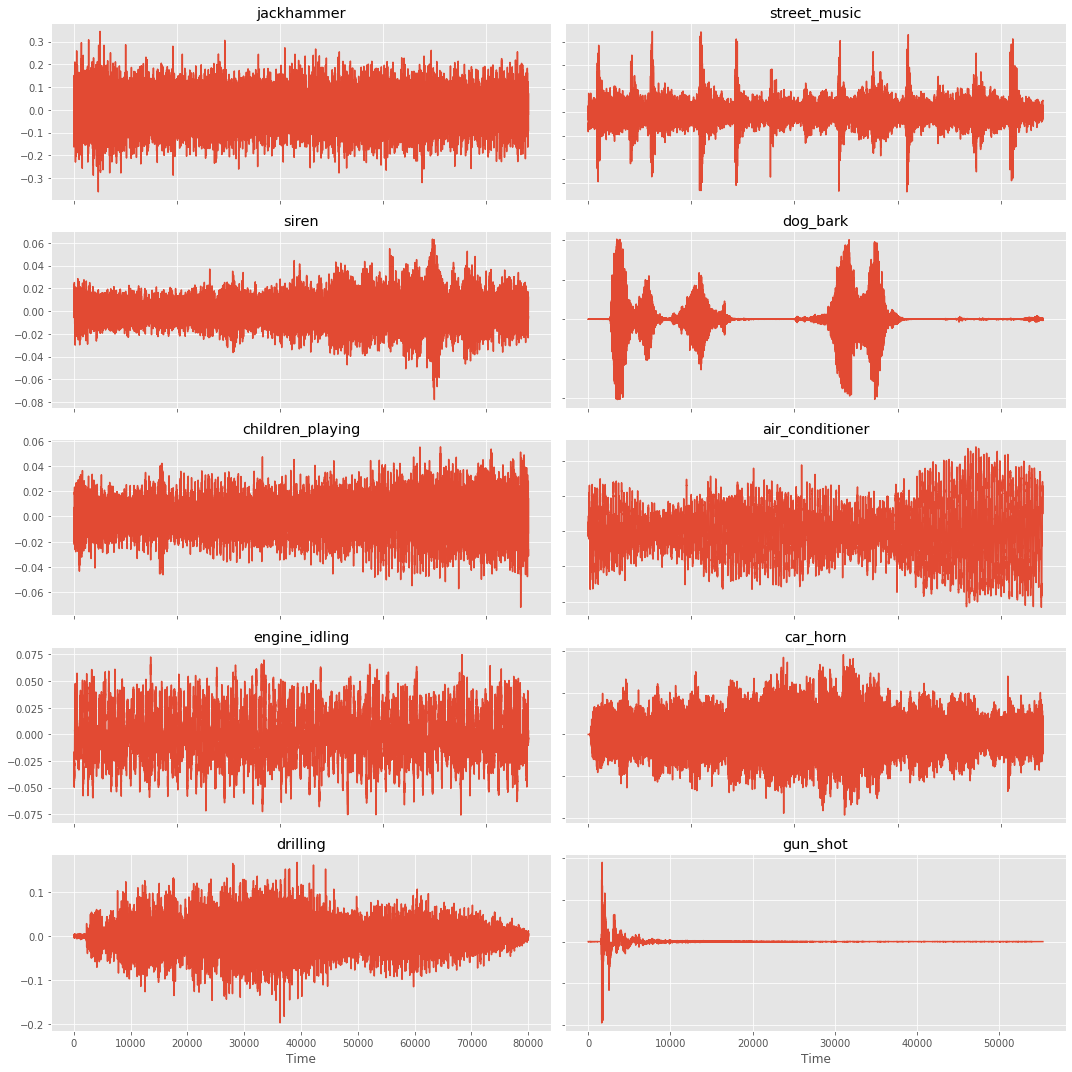

In [153]:
#fig = plt.figure(figsize=(15,15))# Log graphic of waveforms to Comet
# experiment.log_image('class_examples.png')
#fig.subplots_adjust(hspace=0.4, wspace=0.4)

import math
max_rows = math.ceil(len(all_keys)/2)

fig, axs = plt.subplots(nrows=max_rows, ncols=2, constrained_layout=False)
#fig.suptitle('Visualize Wav Files')
fig.set_size_inches(15, 15)

for i, label in enumerate(all_keys):
    fn = wav_files[label][0]

    row = int(i / 2)
    col = i % 2
    
    # TODO(csaska): need something here
    #fig.add_subplot(5, 2, i+1)
    #plt.title(label)
    
    # Method 1
    #data, sample_rate = librosa.load(fn)
    #librosa.display.waveplot(data, sr= sample_rate)
    
    # Method 2
    #plot_wav(fn)
    
    # Method 3
    librosa_load, librosa_sampling_rate = librosa.load(fn)
    # scipy_sampling_rate, scipy_load = wav.read(fn)
    if max_rows == 1:
        #naxs[col].plot(scipy_load)
        #axs[col].set_title(label)
        plot_wav(fn, label)
    else:
        axs[row, col].plot(librosa_load)
        axs[row, col].set_title(label)
    
for ax in axs.flat:
    ax.set(xlabel='Time')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plt.tight_layout()
plt.savefig('class_examples.png')

Text(0, 0.5, 'number of samples')

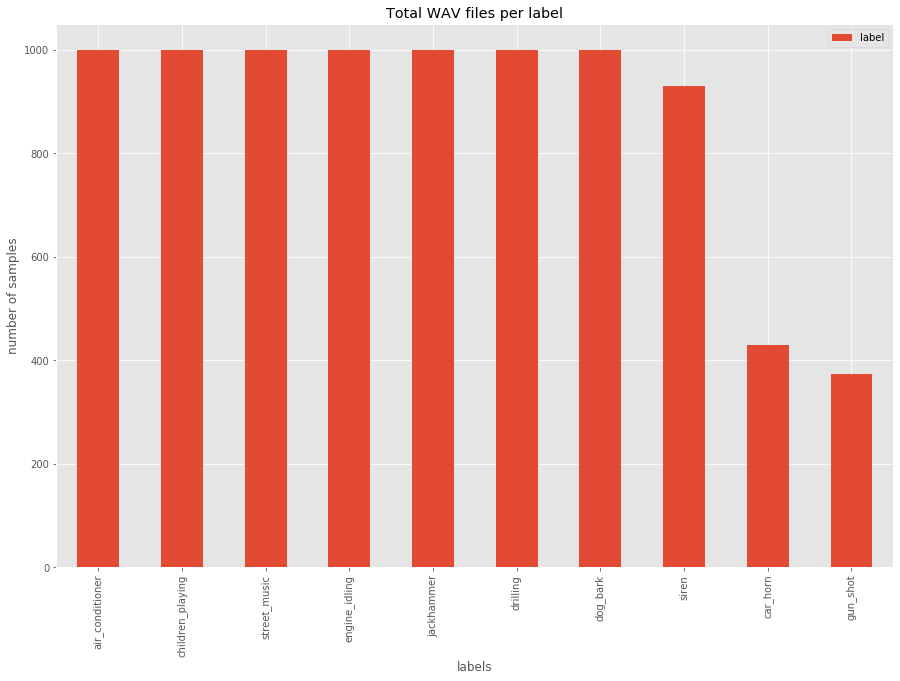

In [141]:
temp = df['label'].value_counts().to_frame()
ax = temp.plot(kind="bar", title='Total WAV files per label', figsize=(15,10), rot=90)
ax.set_xlabel("labels")
ax.set_ylabel("number of samples")

In [166]:
# Plot
#ax = temp[temp['label'] > 200].plot(kind="bar", title='Total WAV files per label')
#ax.set_xlabel("labels")
#ax.set_ylabel("number of samples")

In [170]:
# Plot total seconds of WAV files per label
#metadata = pd.read_csv("./data/UrbanSound8K/metadata/UrbanSound8K.csv")
#metadata['seconds'] = metadata['end'] - metadata['start']
#temp = metadata[['class', 'seconds']]
#temp = temp.groupby(['class']).sum()
#ax = temp.plot(kind="bar", title='Total Seconds per Label', figsize=(15,10), rot=90)
#ax.set_xlabel("labels")
#ax.set_ylabel("total time in seconds")

## Section 2: Reducing noise and trimming silent parts

In [ ]:
#print(wav_files['crow'][1])

In [ ]:
####### Visualize noise reduction #######
# Load audio file
#  Librosa by default:
#    - converts the sampling rate to 22.05 KHz, 
#    - normalise the data so the bit-depth values range between -1 and 1,
#    - and flattens the audio channels into mono.

# Cat example:
#one_file = './data/kaggle_cats_dogs/cats_dogs/cat_147.wav'

# Crow example:
one_file = "./data/environmental-sound-classification-50/audio/2-108767-B-9.wav"

# Frog example:
#one_file = "./data/environmental-sound-classification-50/audio/3-83527-A-4.wav"

audio_data, sampling_rate = librosa.load(one_file)

# Cat example
#noisy_part = audio_data[0:50000]

# Crow example:
noisy_part = audio_data[8000:10000]  # This particular section has nothing but noise

# Frog Example
#noisy_part = audio_data[40000:70000]  # This particular section has nothing but noise


# Noise reduction
reduced_noise = nr.reduce_noise(audio_clip=audio_data, noise_clip=noisy_part, verbose=True, pad_clipping=True)

In [ ]:
# Visualize
print("Original audio file:")
display_wav(audio_data)
print("Noise removed audio file:")
display_wav(reduced_noise)

In [ ]:
####### Trim unnecessary silence #######
trimmed, index = librosa.effects.trim(reduced_noise, top_db=20, frame_length=512, hop_length=64)
print("Trimmed audio file:")
display_wav(trimmed)

In [ ]:
####### Listen to original wav file #######
import IPython.display as ipd
ipd.Audio(one_file)

In [ ]:
####### Listen to noised-reduced wav file #######
base, filename = os.path.split(one_file)
filename, _ = os.path.splitext(filename)
reduced_file = base + '/' + filename + '-noised-reduced.wav'
wav.write(reduced_file, sampling_rate, reduced_noise)
ipd.Audio(reduced_file)

In [ ]:
####### Listen to noised-reduced and trimmed (processed) wav file #######
base, filename = os.path.split(one_file)
filename, _ = os.path.splitext(filename)
processed_file = base + '/' + filename + '-processed.wav'
wav.write(processed_file, sampling_rate, trimmed)
ipd.Audio(processed_file)

## Concatenate entire class samples into one wav file

In [ ]:
wav_concat = dict()
for i, label in enumerate(wav_files.keys()):
    for fn in wav_files[label]:
        librosa_load, librosa_sampling_rate = librosa.load(fn)
        # scipy_sampling_rate, scipy_load = wav.read(fn)
        if label not in wav_concat:
            wav_concat[label] = librosa_load
        else:
            wav_concat[label] = np.concatenate((wav_concat[label], librosa_load))
    wav.write('/Users/Colton.Saska@ibm.com/Downloads/' + label + '.wav', sampling_rate, wav_concat[label])

In [ ]:
ipd.Audio('/Users/Colton.Saska@ibm.com/Downloads/' + list(wav_files.keys())[0] + '.wav')

In [ ]:
display_wav(wav_concat[list(wav_files.keys())[0]])

In [ ]:
reduced_noise = nr.reduce_noise(audio_clip=wav_concat[list(wav_files.keys())[0]], noise_clip=noisy_part, pad_clipping=True)
wav.write('/Users/Colton.Saska@ibm.com/Downloads/crow-reduced.wav', sampling_rate, reduced_noise)
ipd.Audio('/Users/Colton.Saska@ibm.com/Downloads/crow-reduced.wav')

In [ ]:
display_wav(reduced_noise)

In [ ]:
import random
def get_random_wav(files):
    return random.choice(files)

In [ ]:
fn = get_random_wav(wav_files['frog'])
print(fn)
ipd.Audio(fn)

In [ ]:
audio_data, sampling_rate = librosa.load(fn)
display_wav(audio_data)

## Section 3: Trim all wav files

In [ ]:
for fname in all_files:
    librosa_load, librosa_sampling_rate = librosa.load(fname)
    # scipy_sampling_rate, scipy_load = wav.read(fname)
    #trimmed, index = librosa.effects.trim(librosa_load, top_db=20, frame_length=512, hop_length=64)
    
    noisy_part
    trimmed_file = nr.reduce_noise(audio_clip=audio_data, noise_clip=noisy_part, verbose=False, pad_clipping=True)
    
    base, filename = os.path.split(fname)
    filename, _ = os.path.splitext(filename
                                  )
    trimmed_file = base + '/' + filename + '-processed.wav'
    wav.write(trimmed_file, librosa_sampling_rate, trimmed)